In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

TRAIN_PATH='images/train'
TEST_PATH='images/test'
LABELS_PATH='images/labels.yaml'
ANNOTATIONS_PATH='images/annotations.csv'

In [2]:
# files = os.listdir(TRAIN_PATH)
# numfiles = len(files)
# images = []
# for imfile in files:
#     if imfile.endswith('.yaml'):
#         continue
#     images.append(Image.open(os.path.join(TRAIN_PATH, imfile)))

# _, axes = plt.subplots(nrows=int(numfiles/5), ncols=5, figsize=(20, 20))
# for ax, image, filename in zip([i for row in axes for i in row], images, files):
#     ax.set_axis_off()
#     ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
#     ax.set_title(f"Training: {filename}")

# labels
# locomotor
# incendio
# descendo
# tarantallegra - w thing
# arresto_momemtum - m thing
# specialis - s thing
# mimblewimble - sideways s thing


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(1)

In [4]:
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         # transforms.Normalize((0.1307,), (0.3081,)),
#         transforms.Resize((100,100))
#     ]
# )

import yaml

with open(LABELS_PATH) as f:
    label_map = yaml.load(f, Loader=yaml.SafeLoader)["labels"]
annotations = pd.read_csv(ANNOTATIONS_PATH)
all_images = []
imfiles = os.listdir(TRAIN_PATH)
for imfile in imfiles:
    if imfile.endswith(".yaml"):
        continue
    label = annotations[annotations.filename == os.path.join(TRAIN_PATH, imfile)]
    if label.empty:
        continue    
    all_images.append(
        [
            np.reshape(
                    np.array(
                        Image.open(os.path.join(TRAIN_PATH, imfile)), dtype=np.float32
                    ),
                (1, 40, 40),
            ),
            label_map[label.label.item()],
        ]
    )

splits = train_test_split(all_images)

train_loader = torch.utils.data.DataLoader(splits[0], batch_size=10)
test_loader = torch.utils.data.DataLoader(splits[1], batch_size=10)

In [5]:
# _, axes = plt.subplots(nrows=10, ncols=train_loader.batch_size, figsize=(20, 20))
# for ax, image, filename in zip([i for row in axes for i in row], [i[0] for batch in train_loader for i in batch], [i[1] for batch in train_loader for i in batch]):
#     ax.set_axis_off()
#     ax.imshow(image.reshape(40,40), cmap=plt.cm.gray_r, interpolation="nearest")
#     ax.set_title(f"Training: {filename}")
img = [i[0] for batch in train_loader for i in batch][0]

In [6]:
i = Image.fromarray(img.numpy().reshape(40,40))

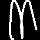

In [7]:
i.convert("RGB")

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        # self.conv2 = nn.Conv2d(4, 8, 3, 1)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1444, 64)
        self.fc2 = nn.Linear(64, 8)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.conv2(x)
        # x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [9]:
model = Net().to('cuda')
optimizer = optim.Adadelta(model.parameters(), lr=.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        del data
        del target

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [11]:
for epoch in range(1, 20 + 1):
    train(model, 'cuda', train_loader, optimizer, epoch)
    test(model, 'cuda', test_loader)
    scheduler.step()

Train Epoch: 1 [0/347 (0%)]	Loss: 29.225262
Train Epoch: 1 [20/347 (6%)]	Loss: 20.730671
Train Epoch: 1 [40/347 (11%)]	Loss: 18.171814
Train Epoch: 1 [60/347 (17%)]	Loss: 7.365547
Train Epoch: 1 [80/347 (23%)]	Loss: 10.743946
Train Epoch: 1 [100/347 (29%)]	Loss: 14.372116
Train Epoch: 1 [120/347 (34%)]	Loss: 12.594039
Train Epoch: 1 [140/347 (40%)]	Loss: 12.242796
Train Epoch: 1 [160/347 (46%)]	Loss: 8.279393
Train Epoch: 1 [180/347 (51%)]	Loss: 18.288280
Train Epoch: 1 [200/347 (57%)]	Loss: 6.290343
Train Epoch: 1 [220/347 (63%)]	Loss: 6.261518
Train Epoch: 1 [240/347 (69%)]	Loss: 4.283874
Train Epoch: 1 [260/347 (74%)]	Loss: 3.593957
Train Epoch: 1 [280/347 (80%)]	Loss: 16.340118
Train Epoch: 1 [300/347 (86%)]	Loss: 1.070534
Train Epoch: 1 [320/347 (91%)]	Loss: 3.417746
Train Epoch: 1 [238/347 (97%)]	Loss: 3.044662

Test set: Average loss: 0.9538, Accuracy: 103/116 (89%)

Train Epoch: 2 [0/347 (0%)]	Loss: 3.366131
Train Epoch: 2 [20/347 (6%)]	Loss: 3.076607
Train Epoch: 2 [40/347 (11

In [12]:
torch.save(model.state_dict(), "wand_cnn.pt")